In [37]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer

from scipy.stats import skew

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [38]:
# Read data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [39]:
target = df_train[df_train.columns.values[-1]]
target_log = np.log(target)

In [40]:
# Merge train and test
df = df_train[df_train.columns.values[:-1]].append(df_test, ignore_index = True)

In [41]:
# Find categorical and numerical data
cats = []
for col in df.columns.values:
    if df[col].dtype == "object":
        cats.append(col)
df_cat = df[cats]
df_num = df.drop(cats, 1)

In [42]:
# Log transform for numerical data
for col in df.columns.values:
    if df[col].dtype != "object":
        df[col] = np.log(df[col])

/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


In [43]:
df = df.replace(-np.inf, -999)

In [44]:
# Find the correlation matrix
corrmat = df_train.drop('Id', 1).corr()

In [45]:
k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cols = cols.drop('SalePrice')

In [46]:
# Use most important 10 numerical factor as numerical data
df_num = df[cols]

In [47]:
for col in df_num.columns.values:
    if np.sum(df_num[col].isnull()) > 0:
        median = df_num[col].median()
        idx = np.where(df_num[col].isnull())[0]
        df_num[col].iloc[idx] = median

/Users/jianghanyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [48]:
# Check if there is missing data in the numerical data
total = df_num.isnull().sum().sort_values(ascending=False)
percent = (df_num.isnull().sum()/df_num.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data # Not missing data

,Total,Percent
YearRemodAdd,0,0.0
YearBuilt,0,0.0
TotRmsAbvGrd,0,0.0
FullBath,0,0.0
1stFlrSF,0,0.0
TotalBsmtSF,0,0.0
GarageArea,0,0.0
GarageCars,0,0.0
GrLivArea,0,0.0
OverallQual,0,0.0


In [49]:
# Missing data for categorical ones
total = df_cat.isnull().sum().sort_values(ascending=False)
percent = (df_cat.isnull().sum()/df_cat.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageFinish,159,0.054471
GarageType,157,0.053786
BsmtCond,82,0.028092


In [50]:
# Delete the categorical data with more than 50 missing data
df_cat = df_cat.drop((missing_data[missing_data['Total']>83]).index, 1)
# Replace the missing categorical data with "MISS"
for col in df_cat.columns.values:
    if df_cat[col].isnull().sum() > 0:
        df_cat[col] = df_cat[col].fillna('MISS')
df_cat = pd.get_dummies(df_cat)

In [70]:
# Merge numerical and categorical data
df_new = df_num.join(df_cat)
df_new['IsRemod'] = 1 * np.array(df_new['YearRemodAdd'] != df_new['YearBuilt'])

df_train = df_new.iloc[:len(df_train) - 1]
df_train = df_train.join(target_log)

df_test = df_new.iloc[len(df_train) + 1:]

X_train = df_train[df_train.columns.values[1:-1]]
y_train = df_train[df_train.columns.values[-1]]

X_test = df_test[df_test.columns.values[1:]]

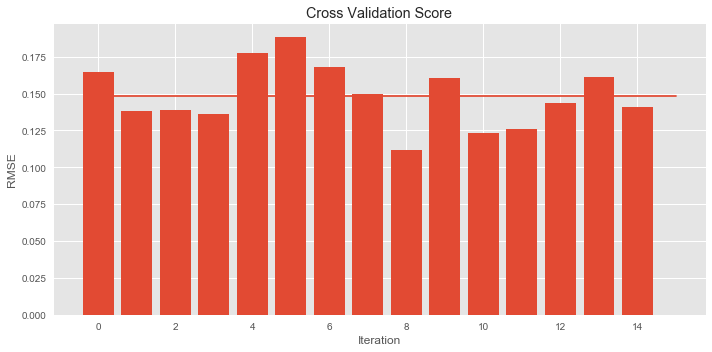

In [58]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)

clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
cv_score = np.sqrt(-cross_val_score(estimator=clf, X=X_train, y=y_train, cv=15, scoring = scorer))

plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()

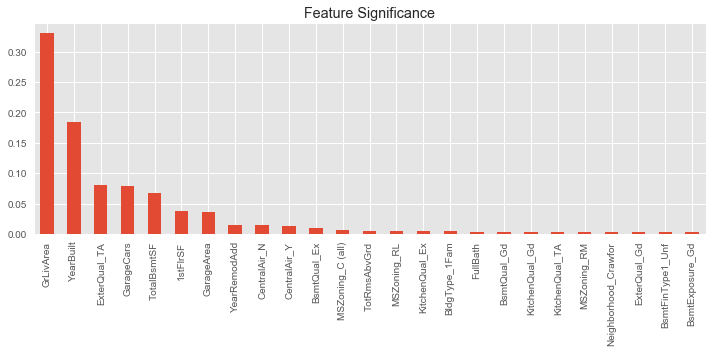

In [71]:
# Fit model with training data
clf.fit(X_train, y_train)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [72]:
my_clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
my_clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [73]:
y_pred = my_clf.predict(X_test)
y_pred = np.exp(y_pred)

In [78]:
len(y_pred)

1462

In [76]:
# Submission
sub = pd.DataFrame()
df_test = pd.read_csv('test.csv')
sub['Id'] = df_test["Id"]
sub['SalePrice'] = y_pred
sub.to_csv('submission.csv',index=False)

ValueError: Length of values does not match length of index